In [1]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

In [2]:
def absolute_path_joiner(img_path: str):
    new_path = os.path.join(os.getcwd(), img_path)
    return new_path

## Load Image

In [3]:
SAMPLE_IMAGE_DIR = "../../../resources/need_annotating/OLOMBENDO/"
random.seed(42)
sample_images = random.choices(os.listdir(SAMPLE_IMAGE_DIR), k=10)
sample_image_paths = [os.path.join(SAMPLE_IMAGE_DIR, img) for img in sample_images]
sample_image_paths = [absolute_path_joiner(img) for img in sample_image_paths]
flags = []
imgs = [cv.imread(img_path, cv.IMREAD_GRAYSCALE) for img_path in sample_image_paths]
imgs_blurred = [cv.GaussianBlur(img, (5, 5), 0) for img in imgs]
imgs_binary = [cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1] for idx, img in enumerate(imgs_blurred)]
imgs_binary_for_ratio = [img.copy() for img in imgs_binary]
#img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_cmap = plt.get_cmap("gray")

## Detect Boundary Candidates and Crop

In [4]:
import cv2
from crop_utils import (
    find_boundary_lines,
    get_figure_and_table_boundaries,
    extract_regions,
    translate_ocr_coordinates,
    find_inner_border_edges,
    find_edge_buffers,
    find_outer_border_edges,
)

In [14]:
img_no = 4

boundary_info = find_boundary_lines(
    imgs[img_no],
    imgs_blurred[img_no],
    canny_thresh1=50,
    canny_thresh2=200,
    hough_thresh=100,
    min_line_length=450,
    max_line_gap=20,
    angle_tolerance=5,
)

img_h, img_w, vert_lines, horz_lines = boundary_info

# Find Border Buffers
buffers = find_edge_buffers(
    imgs_binary_for_ratio[img_no],
    scan_depth_px=80,
    artifact_threshold_alpha=0.75,  # Tune this
    slice_step_px=3,
)
print(f"Calculated Buffers: {buffers}")

# Find Outer Border Edges (using white space)
outer_edges = find_outer_border_edges(
    imgs_binary_for_ratio[img_no],
    buffers,
    border_start_threshold_alpha=0.03, # Tune this
    slice_step_px=3,
    max_whitespace_ratio=0.1
    )

# Find Inner Border Edges (using lines)
if outer_edges and horz_lines is not None and vert_lines is not None:
    inner_boundaries = find_inner_border_edges(
        outer_edges,
        horz_lines,
        vert_lines,
        expected_border_thickness_px=120,  # Tune this
        search_buffer_px=60,
    )  # Tune this buffer
    print(f"Calculated Inner Boundaries: {inner_boundaries}")

# Extract Regions (using the final inner_boundaries)
if inner_boundaries:
    # Map inner_boundaries to the format expected by extract_regions
    # Note: The keys might need slight adjustment based on the exact output
    # of find_inner_border_edges and input of extract_regions_with_offsets
    final_boundaries_for_crop = {
        "y_top": inner_boundaries["top"],
        "y_bottom": inner_boundaries["bottom"],
        "x_left": inner_boundaries["left"],
        "x_divider": inner_boundaries["divider"],
        "x_right": inner_boundaries[
            "table_right"
        ],  # Use the table's right edge
    }

    figure_crop, table_crop, fig_offset, tab_offset = (
        extract_regions(
            imgs[img_no],
            final_boundaries_for_crop,
            padding=5,  # Adjust padding as needed
        )
    )


"""boundaries = get_figure_and_table_boundaries(
    img_h,
    img_w,
    vert_lines,
    horz_lines,
    border_margin_ratio=0.049,
    max_crawl_ratio=0.07,
    divider_search_ratio_start=0.776,
    edge_buffer_px=80,
)

figure_crop, table_crop, figure_offset, table_offset = extract_regions(imgs[img_no], boundaries, padding=10)"""

Detected 77 potential vertical lines.
Detected 141 potential horizontal lines.
Artifact detected: Top
  Top buffer set to: 57px
Artifact detected: Left
  Left buffer set to: 78px
Artifact detected: Right
  Right buffer set to: 3px
Calculated Buffers: {'top': 57, 'bottom': 0, 'left': 78, 'right': 3}
Outer border found - Top: 57px
Outer border found - Bottom: 3367px
Outer border found - Left: 78px
Outer border found - Right: 4764px
Inner border found - Top: 114px (search band 57-237)
Inner border found - Bottom: 3255px (search band 3187-3367)
Inner border found - Left: 136px (search band 78-258)
Inner border found - Right: 4631px (search band 4584-4764)
Divider search range: 3732px to 4581px
Divider line found at x=3898px (selected rightmost)
Calculated Inner Boundaries: {'top': 114, 'bottom': 3255, 'left': 136, 'divider': 3898, 'table_right': 4631}
Figure extracted: shape=(3131, 3752) at offset (141, 119)
Table extracted: shape=(3131, 723) at offset (3903, 119)


'boundaries = get_figure_and_table_boundaries(\n    img_h,\n    img_w,\n    vert_lines,\n    horz_lines,\n    border_margin_ratio=0.049,\n    max_crawl_ratio=0.07,\n    divider_search_ratio_start=0.776,\n    edge_buffer_px=80,\n)\n\nfigure_crop, table_crop, figure_offset, table_offset = extract_regions(imgs[img_no], boundaries, padding=10)'

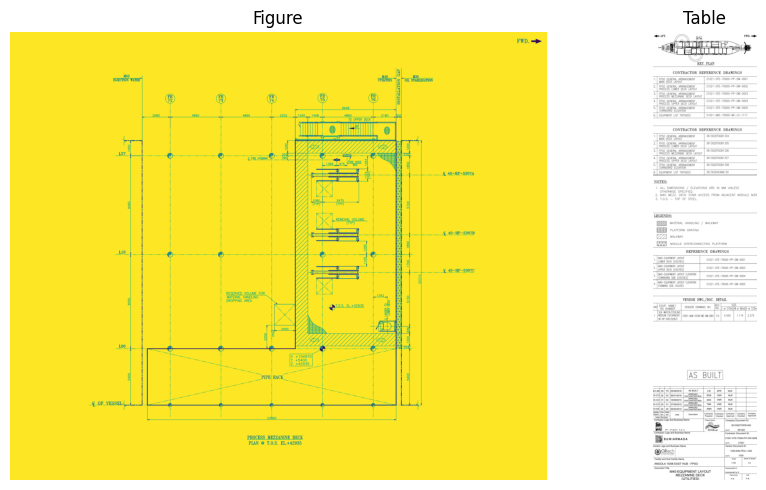

In [15]:
if figure_crop is not None and table_crop is not None:
    # --- Resizing ---
    display_scale = 0.4
    figure_display = None
    table_display = None

    if figure_crop.shape[1] > 0 and figure_crop.shape[0] > 0:
        figure_display = cv2.resize(
            figure_crop,
            (
                int(figure_crop.shape[1] * display_scale),
                int(figure_crop.shape[0] * display_scale),
            ),
            interpolation=cv2.INTER_AREA,  # Specify interpolation for resizing
        )
    else:
        print("Warning: Figure crop resulted in zero dimension.")

    if table_crop.shape[1] > 0 and table_crop.shape[0] > 0:
        table_display = cv2.resize(
            table_crop,
            (
                int(table_crop.shape[1] * display_scale),
                int(table_crop.shape[0] * display_scale),
            ),
            interpolation=cv2.INTER_AREA,  # Specify interpolation for resizing
        )
    else:
        print("Warning: Table crop resulted in zero dimension.")

    # --- Displaying Side-by-Side ---
    # Check if both resized images are valid before trying to plot
    if figure_display is not None and table_display is not None:
        # Create a figure and a set of subplots
        # plt.subplots(nrows, ncols, figsize=(width, height))
        # For side-by-side, we want 1 row, 2 columns
        fig, axes = plt.subplots(
            1, 2, figsize=(10, 5)
        )  # Adjust figsize as needed

        # axes is an array of Axes objects. axes[0] is the first subplot, axes[1] is the second.

        # Display the first image on the left subplot (axes[0])
        axes[0].imshow(figure_display)
        axes[0].set_title("Figure")
        axes[0].axis("off")  # Hide axes ticks and labels

        # Display the second image on the right subplot (axes[1])
        # Use the grayscale colormap defined earlier
        axes[1].imshow(table_display, cmap=gray_cmap)
        axes[1].set_title("Table")
        axes[1].axis("off")  # Hide axes ticks and labels

        # Adjust layout to prevent titles/images from overlapping
        plt.tight_layout()

        # Show the figure window with both subplots
        plt.show()

Image 4 of 10 with shape (3392, 4768)


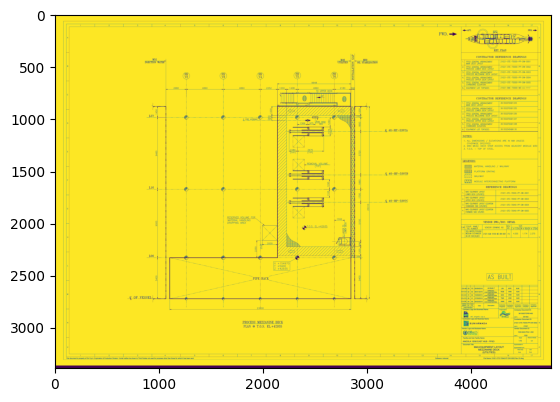

In [16]:
print(f"Image {img_no} of {len(imgs)} with shape {imgs[img_no].shape}")
plt.imshow(imgs[img_no][:,:])

In [8]:
np.unique(imgs[img_no][-30:,:])

array([  0,  18,  20,  56,  75,  99, 108, 110, 127, 137, 148, 156, 174,
       176, 177, 179, 181, 193, 195, 197, 201, 210, 218, 219, 223, 236,
       238, 247, 250, 253, 255], dtype=uint8)

## Translate OCR Results From Crop -> Original Image Coordinate System

In [17]:
figure_ocr = [
    {"text": "VE-30-10", "bbox": [50, 100, 80, 20], "confidence": 0.99},
]

table_ocr = [
    {"text": "Contractor:", "bbox": [50, 200, 80, 20], "confidence": 0.99},
]

ocr_absolutes = translate_ocr_coordinates(figure_ocr, table_ocr, fig_offset, tab_offset)

Translated coordinates for 2 OCR results.


In [18]:
ocr_absolutes

[{'text': 'VE-30-10',
  'bbox': [191, 219, 80, 20],
  'confidence': 0.99,
  'source_crop': 'figure'},
 {'text': 'Contractor:',
  'bbox': [3953, 319, 80, 20],
  'confidence': 0.99,
  'source_crop': 'table'}]